In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def cv_show(img):
    cv2.imshow('cv_show', img)
    cv2.waitKey(0)  # 等待时间，毫秒级，0标示按任意键终止
    cv2.destroyAllWindows()
    cv2.waitKey(1)  # 解决mac中窗口不关闭的问题
    
def showImages(images, titles = [''], size = [1, 1], BGR = False):
    for i in range(len(images)):
        plt.subplot(size[0], size[1], i + 1)
        showImage = images[i]
        if (BGR):
            b,g,r = cv2.split(images[i])
            showImage = cv2.merge([r,g,b])
        plt.imshow(showImage ,'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

In [4]:
# 色彩空间转换：⬇️
# https://blog.csdn.net/keith_bb/article/details/53470170?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1.pc_relevant_default&utm_relevant_index=2

img = cv2.imread(
    '/Users/zhouxinyu/Code/Python/vision/images/red.jpg', cv2.IMREAD_COLOR)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

pollutionImg = cv2.imread(
    '/Users/zhouxinyu/Code/Data/ZF-Vision/wuran.png', cv2.IMREAD_COLOR)
pollutionHSV = cv2.cvtColor(pollutionImg, cv2.COLOR_BGR2HSV)
pollutionGRAY = cv2.cvtColor(pollutionImg, cv2.COLOR_BGR2GRAY)

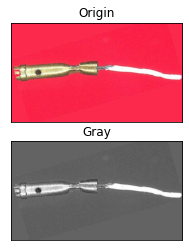

In [5]:
showImages([
    cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB),
    gray
], ['Origin','Gray'], [2, 1])

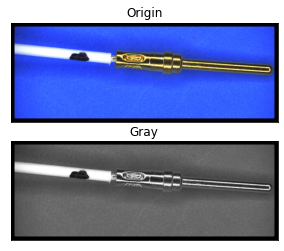

In [6]:
showImages([
    cv2.cvtColor(pollutionHSV, cv2.COLOR_HSV2RGB),
    pollutionGRAY
], ['Origin','Gray'], [2, 1])

# 通过阈值进行二值化
步骤：
1. 读取图片，并转换到HSV色彩空间；
2. 设定阈值，对背景和线缆进行二值化处理；
3. 选择线缆部分为ROI（白色），依次进行：腐蚀、膨胀、中值滤波

In [7]:
# HSV中H的取值范围是[0, 180]，其中H=0是标准的红色
# sensitivity是围绕0的浮动，sensitivity=10时表示认定[0, 10] and [170, 180]都是红色
# 即[0, sensitivity] and [180 - sensitivity, 180]是红色范围
def binarize(hsvImage, sensitivity = 10, lower = 0, upper = 255):
    red_positive = np.array([
        [0, lower, lower],
        [sensitivity, upper, upper]
    ])
    red_reverse = np.array([
        [180 - sensitivity, lower, lower],
        [180, upper, upper]
    ])
    mask_positive = cv2.inRange(hsvImage, red_positive[0], red_positive[1])
    mask_reverse = cv2.inRange(hsvImage, red_reverse[0], red_reverse[1])
    return cv2.bitwise_not(cv2.bitwise_or(mask_positive, mask_reverse))

In [8]:
def binarizeBlue(hsvImage):
    lower_blue=np.array([100,43,46])
    upper_blue=np.array([124,255,255])
    mask = cv2.inRange(hsvImage, lower_blue, upper_blue)
    return cv2.bitwise_not(mask)

In [9]:
cv_show(binarizeBlue(pollutionHSV))

In [10]:
kernel = np.ones((2,2), np.uint8)
blue_binarized = binarizeBlue(pollutionHSV)

In [11]:
#膨胀
dilate_bluw = cv2.dilate(blue_binarized, kernel, iterations = 1)
cv_show(dilate_bluw)

In [12]:
#腐蚀
erosion_blue = cv2.erode(blue_binarized, kernel, iterations = 5)
cv_show(erosion_blue)

In [13]:
erosion_blue_pz = cv2.dilate(erosion_blue, kernel, iterations = 2)
cv_show(erosion_blue_pz)

In [14]:
def binarizeWhite(hsvImage):
    lower=np.array([0,0,221])
    upper=np.array([180,80,255])
    mask = cv2.inRange(hsvImage, lower, upper)
    return mask

In [15]:
cv_show(binarizeWhite(pollutionHSV))

In [16]:
white_binarized = binarizeWhite(pollutionHSV)

In [17]:
cv_show(cv2.bitwise_and(
    white_binarized,
    blue_binarized
))

In [18]:
def imageProcessing(img):
    # 闭：先膨胀，再腐蚀
    closing_kernel = np.ones((5,5), np.uint8)
    erosion_kernel = np.ones((10,10), np.uint8)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, closing_kernel)

In [19]:
def drawEdge(counterImg):
    de_contours, de_hierarchy = cv2.findContours(counterImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    de_res = cv2.drawContours(cv2.cvtColor(counterImg, cv2.COLOR_GRAY2BGR), de_contours, -1, (255, 0, 0), 10)
    return de_res, de_contours

2


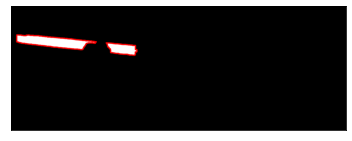

In [20]:
# 闭：先膨胀，再腐蚀
closing_kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(white_binarized, cv2.MORPH_CLOSE, closing_kernel)

# 开：先腐蚀，再膨胀
# opening_kernel = np.ones((5,5), np.uint8)
# opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, opening_kernel)

# cv_show(np.hstack((white_binarized, opening)))

erosion_c_white = cv2.erode(closing, np.ones((10,10), np.uint8), iterations = 2)
res_test_de, res_test_countours = drawEdge(erosion_c_white)
print(len(res_test_countours))
showImages([res_test_de])


In [21]:
#膨胀
dilate_white = cv2.dilate(white_binarized, kernel, iterations = 5)
dilate_white_copy = dilate_white.copy()
cv_show(dilate_white)

In [22]:
w_contours, w_hierarchy = cv2.findContours(dilate_white, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [23]:
color = cv2.cvtColor(dilate_white, cv2.COLOR_GRAY2BGR)
circle_img = cv2.drawContours(color, w_contours, -1, (0, 0, 255), 2)
cv_show(circle_img)

In [24]:
# 腐蚀
erosion_white = cv2.erode(dilate_white, kernel, iterations = 10)
cv_show(erosion_white)

In [25]:
cv_show(
    cv2.bitwise_or(
        binarizeWhite(pollutionHSV),
        binarizeBlue(pollutionHSV)
    )
)

In [26]:
def dispose(binImg):
    core = (20, 20)
    # 中值滤波
    return cv2.medianBlur(
    # 腐蚀
        cv2.erode(
            # 膨胀
            cv2.dilate(
                binImg,
                core,
                iterations=10
            ),
            core,
            iterations=10
        ),
        15
    )

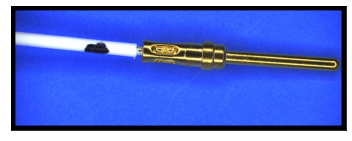

In [27]:
showImages([cv2.cvtColor(pollutionHSV, cv2.COLOR_HSV2RGB)]) # 显示一张RGB图片

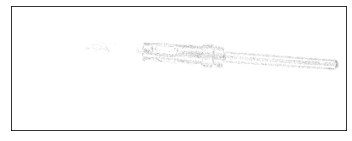

In [28]:
# 把背景色去掉，二值化处理
binPollutionImg = binarize(pollutionHSV, lower = 10)
showImages([binPollutionImg])

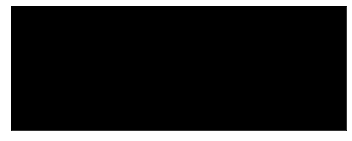

In [29]:
# 膨胀 + 腐蚀 + 中值滤波
showImages([dispose(binPollutionImg)])

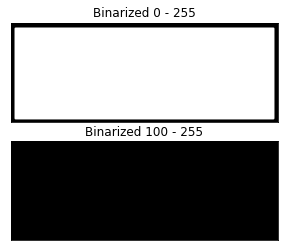

In [30]:
# 所有操作一句写完
showImages(
    [
#         cv2.cvtColor(pollutionHSV, cv2.COLOR_HSV2RGB),
        dispose(
            binarize(pollutionHSV, lower = 0)
        ),
        dispose(
            binarize(pollutionHSV, lower = 100)
        )
    ],
    ['Binarized 0 - 255', 'Binarized 100 - 255'],
    [2, 1]
)

# 使用边缘检测判断图片是否污染

## Sobel算子

In [31]:
def getSobel(img):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = 3)
    sobel_x = cv2.convertScaleAbs(sobel_x)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = 3)
    sobel_y = cv2.convertScaleAbs(sobel_y)
    return cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

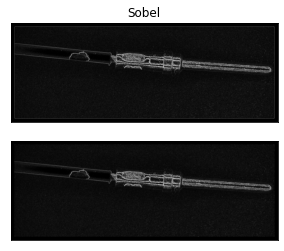

In [32]:
showImages([
    getSobel(pollutionGRAY),
    cv2.medianBlur(getSobel(pollutionGRAY), 5)
], [
    'Sobel',
    ''
],[2,1])
cv_show(getSobel(pollutionGRAY))


In [33]:
retval, dst = cv2.threshold(getSobel(pollutionGRAY), 125, 255, cv2.THRESH_BINARY )
# showImages([dst])
cv_show(dst)

In [34]:
res = cv2.erode(
    dst
    , (1,1), iterations=1)
cv_show(res)

In [35]:
edge = cv2.Canny(res, 1, 9, 1)
cv_show(edge)

In [36]:
cv2.erode(
            # 膨胀
            cv2.dilate(
                binImg,
                core,
                iterations=10
            ),
            core,
            iterations=10
        ),
        15
    
    

IndentationError: unexpected indent (4035537035.py, line 11)

In [ ]:
core2 = (1, 1)
res = cv2.erode(
    dst
    , core2, iterations=1)
cv_show(res)

## scharr算子

## laplacian算子

## Isotropic Sobel算子

In [ ]:
def getIsotropicSobel(img):
    return ''

## Canny边缘检测
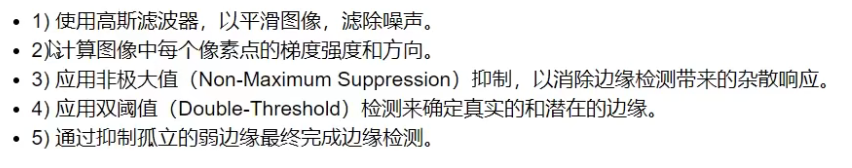

# 测试边缘检测


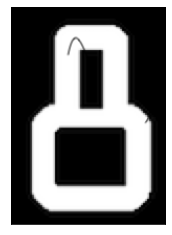

In [ ]:
# 读入银行卡数字的模板图片 灰度图
template = cv2.imread('/Users/zhouxinyu/Code/Data/clutter/8new.png')
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
showImages([template_gray])

template_ret ->  127.0


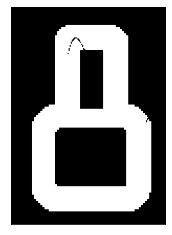

In [ ]:
# 对模板图片进行二值化
template_ret, template_thresh = cv2.threshold(template_gray, 127, 255, cv2.THRESH_BINARY)
print("template_ret -> ", template_ret)
showImages([template_thresh])

In [ ]:
# 轮廓检测 cv2.RETR_EXTERNAL--检测外侧轮廓
t_contours, t_hierarchy = cv2.findContours(template_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print(contours)

## 绘制轮廓

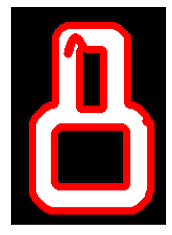

In [ ]:
# 轮廓绘制
t_res = cv2.drawContours(template.copy(), t_contours, -1, (255, 0, 0), 5) #注意这里！！！
showImages([t_res])

In [ ]:
len(t_contours)

13